# SHAP values

## Set-up

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
os.chdir('../..')

In [3]:
from src.models.DeepFantasyFootball.make_predictions import DeepFantasyFootball, load_retro_data
from src.models.constants import SEASON_ORDER_DICT

Using TensorFlow backend.


In [4]:
pd.options.display.max_columns = None

In [5]:
shap.initjs()

In [6]:
RANDOM_SEED = 3

## Make predictions

In [7]:
SEASON_ORDER_DICT

{'2011-12': -4,
 '2012-13': -3,
 '2013-14': -2,
 '2014-15': -1,
 '2015-16': 0,
 '2016-17': 1,
 '2017-18': 2,
 '2018-19': 3,
 '2019-20': 4}

In [8]:
%%time
retro_data = load_retro_data()

CPU times: user 1.73 s, sys: 508 ms, total: 2.24 s
Wall time: 5.74 s


In [9]:
retro_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points,position_DEF,position_FWD,position_GK,position_MID,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek,season_order
4479,1,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0,4
9170,2,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,2.45,1.21,2.41,1.0,0,0,0,0,0,2.30,1.34,2.29,1.0,0.0,0.0,0.0,4
13811,3,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,2.30,1.34,2.29,1.0,0,0,0,0,0,10.67,30.23,0.09,0.0,0.0,1.0,0.0,4
18557,4,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,inf,1.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0,10.67,30.23,0.09,0.0,0,1,0,0,0,2.40,1.14,2.67,1.0,0.0,0.0,0.0,4
23303,5,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,2.2,0.0,0.0,0.0,42.9,0.0,0.0,0.0,50.0,0.0,1.0,0,1,0,0,2.40,1.14,2.67,1.0,0,0,0,0,0,2.22,2.26,1.40,0.0,0.0,0.0,0.0,4


In [10]:
PREVIOUS_GW = 29
PREDICTION_SEASON = '2019-20'
PREDICTION_SEASON_ORDER = SEASON_ORDER_DICT[PREDICTION_SEASON]

In [11]:
lstm_pred = DeepFantasyFootball(
    previous_gw=PREVIOUS_GW,
    prediction_season_order=PREDICTION_SEASON_ORDER,
    previous_gw_was_double_gw=False  # Remove parameter
)

In [12]:
player_list, player_data_list = lstm_pred.prepare_data_for_lstm(full_data=retro_data)

2020-08-19 13:08:48,999 - Number of players available for selection: 65771.0
2020-08-19 13:08:49,184 - Player data shape before: (65771, 86)
2020-08-19 13:08:49,338 - Player data shape after removing players with insufficient GW data: (65771, 86)
2020-08-19 13:08:49,900 - Player data shape after only keeping records needed for LSTM: (2575, 86)


In [13]:
unformatted_predictions = lstm_pred.make_player_predictions(
    player_data_list=player_data_list
)

2020-08-19 13:08:50,733 - LSTM input array shape: (515, 5, 62)


In [14]:
final_predictions = lstm_pred.format_predictions(
    player_list=player_list,
    final_predictions=unformatted_predictions,
    full_data=retro_data,
    double_gw_teams=[]
)

In [15]:
final_predictions.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name
362,4.961932,5.251184,5.102656,5.097271,4.948592,25.361633,mohamed_salah,0,0,0,1,Liverpool
144,6.311263,4.099582,4.186485,3.866956,3.806001,22.270288,ederson_santana de moraes,0,0,1,0,Manchester City
417,5.878163,3.970896,4.101170,3.808395,3.737016,21.495640,raheem_sterling,0,0,0,1,Manchester City
425,4.182103,4.302470,4.288117,4.216527,4.051799,21.041018,richarlison_de andrade,0,0,0,1,Everton
294,5.561547,3.699066,3.986070,3.753380,3.754021,20.754084,kevin_de bruyne,0,0,0,1,Manchester City


In [16]:
plot_df = pd.melt(
    final_predictions[['name', 'GW_plus_1', 'GW_plus_2', 'GW_plus_3', 'GW_plus_4', 'GW_plus_5']], 
    id_vars=['name']
)
plot_df.rename(columns={'variable': 'GW', 'value': 'prediction'}, inplace=True)
plot_df.head()

,name,GW,prediction
0,mohamed_salah,GW_plus_1,4.961932
1,ederson_santana de moraes,GW_plus_1,6.311263
2,raheem_sterling,GW_plus_1,5.878163
3,richarlison_de andrade,GW_plus_1,4.182103
4,kevin_de bruyne,GW_plus_1,5.561547


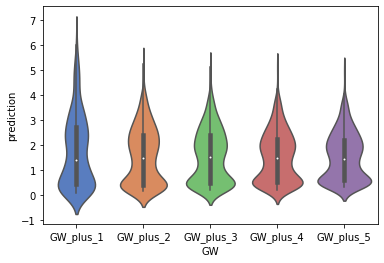

In [17]:
sns.violinplot(x="GW", y="prediction", data=plot_df, palette="muted", split=True)
plt.show()

## SHAP values

### Feature importance

In [18]:
player_data_list[0].shape

(5, 62)

In [19]:
player_data_list[0]

,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points
24,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.648649,0.0,0.036220,0.065603,0.5,0.0,0.0,0.037316,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
25,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.675676,0.0,0.039370,0.025880,0.0,0.5,0.0,0.099308,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
26,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.083333,0.008696,0.0,0.0,0.702703,0.0,0.021260,0.079145,0.5,0.0,0.0,0.034306,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.161290
27,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.729730,0.0,0.065354,0.019862,0.0,0.0,0.0,0.125790,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
28,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.756757,0.0,0.039370,0.036714,0.5,0.0,0.5,0.066205,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129032


In [20]:
input_data_columns = list(player_data_list[0].columns)

In [21]:
# Order of columns after reshaping to 2D
input_data_columns_flattened = \
    [col + '_minus5' for col in input_data_columns] + \
    [col + '_minus4' for col in input_data_columns] + \
    [col + '_minus3' for col in input_data_columns] + \
    [col + '_minus2' for col in input_data_columns] + \
    [col + '_minus1' for col in input_data_columns]

In [22]:
flattened_df = pd.DataFrame(
    player_data_list[0].values.reshape(1, -1),
    columns=input_data_columns_flattened
)

flattened_df

,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

In [23]:
reconstructed_df = pd.DataFrame(
    flattened_df.values.reshape(5, -1),
    columns=input_data_columns
)

reconstructed_df

,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.648649,0.0,0.036220,0.065603,0.5,0.0,0.0,0.037316,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.675676,0.0,0.039370,0.025880,0.0,0.5,0.0,0.099308,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
2,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.083333,0.008696,0.0,0.0,0.702703,0.0,0.021260,0.079145,0.5,0.0,0.0,0.034306,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.161290
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.729730,0.0,0.065354,0.019862,0.0,0.0,0.0,0.125790,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.756757,0.0,0.039370,0.036714,0.5,0.0,0.5,0.066205,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129032


In [24]:
# Check reconstructed data:
for col in input_data_columns:
    np.testing.assert_array_equal(
        player_data_list[0][col],
        reconstructed_df[col]
    )

__Create input array for LSTM by doing above steps for all DataFrames in `player_data_list`__

In [25]:
player_data_flattened_list = [
    pd.DataFrame(
        df.values.reshape(1, -1),
        columns=input_data_columns_flattened
    ) 
    for df in player_data_list
]

player_data_flattened_df = pd.concat(player_data_flattened_list, ignore_index=True)
print(player_data_flattened_df.shape)
player_data_flattened_df.head()

(515, 310)


,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

In [26]:
# Array passed to SHAP functions
lstm_input_array = player_data_flattened_df.values

__Check reconstruction of data from `lstm_input_array`__

In [27]:
player_data_list_reconstructed_test = [
    pd.DataFrame(
        input_array.reshape(5, -1),
        columns=input_data_columns
    ) 
    for input_array 
    in np.array_split(  # Split array into individual flat row arrays
        lstm_input_array,
        lstm_input_array.shape[0]
    )
]

In [28]:
len(player_data_list_reconstructed_test)

515

In [29]:
# Check reconstructed data
reconstructed_concat = pd.concat(player_data_list_reconstructed_test, ignore_index=True)
original_concat = pd.concat(player_data_list, ignore_index=True)

for col in input_data_columns:
    np.testing.assert_array_equal(
        reconstructed_concat[col],
        original_concat[col]
    )

__Create wrapper function around `lstm_pred.make_player_predictions`__

In [30]:
def make_predictions(input_array_2d):
    """
    Wrapper around make_player_predictions which includes the additional step of converting the 2D input array to a list of 3D arrays for each player.
    """
    # 2D input array to list of 3D arrays:
    player_data_list_reconstructed = [
        pd.DataFrame(
            input_array.reshape(5, -1),
            columns=input_data_columns
        ) 
        for input_array 
        in np.array_split(
            input_array_2d,
            input_array_2d.shape[0]
        )
    ]
    
    # Make predictions:
    raw_predictions = lstm_pred.make_player_predictions(
        player_data_list=player_data_list_reconstructed
    )
    
    return raw_predictions['GW_plus_1']

In [31]:
# Test function
make_predictions(lstm_input_array)

2020-08-19 13:09:08,403 - LSTM input array shape: (515, 5, 62)


0      0.421712
1      2.411663
2      0.639980
3      2.848152
4      2.982840
         ...   
510    1.226423
511    0.148716
512    1.805136
513    2.297647
514    0.840282
Name: GW_plus_1, Length: 515, dtype: float32

In [32]:
lstm_input_array.shape

(515, 310)

In [33]:
lstm_input_array

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12903226],
       [0.5       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.19354839],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.16129032],
       ...,
       [1.        , 0.5       , 0.        , ..., 1.        , 0.        ,
        0.16129032],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.22580645],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12903226]])

In [34]:
np.random.seed(RANDOM_SEED)
idx = np.random.randint(lstm_input_array.shape[0], size=100)  # Use 100 random examples in background data
idx

array([249, 256, 119, 422, 480, 423, 398, 504, 337, 474, 258, 316, 413,
       152, 507, 171, 379, 335, 176,  20, 405, 383, 500,   0, 274, 372,
       184, 165, 113,   1, 117, 511, 274, 183, 223, 141, 421, 414, 289,
       308, 497, 508,   2, 156,  36, 176, 182, 496, 484, 497, 277, 295,
       285, 160,   9,  33, 495, 503, 444, 311, 267, 212, 368,  76, 300,
        44, 275, 120, 178,  35, 173, 242,  52, 257,   2, 483, 148,  62,
        22, 476, 441, 481, 252, 309, 363, 100,  26,  60, 133, 212, 503,
       489, 337,   9, 141, 510,  44, 292, 200, 508])

In [35]:
background_data = lstm_input_array[idx, :]
background_data.shape

(100, 310)

In [36]:
explainer = shap.KernelExplainer(make_predictions, background_data.astype(np.float32))

2020-08-19 13:09:11,244 - LSTM input array shape: (100, 5, 62)


In [37]:
# Turn off logs
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [38]:
idx_shap = np.random.randint(lstm_input_array.shape[0], size=50)  # Use 50 random examples to get SHAP values for
test_data = lstm_input_array[idx_shap, :]
test_data.shape

(50, 310)

In [39]:
%%time
shap_values = explainer.shap_values(test_data.astype(np.float32))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


CPU times: user 53min 22s, sys: 2min 12s, total: 55min 35s
Wall time: 50min 15s


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [40]:
shap_values

array([[-0.00412536,  0.        , -0.00686971, ..., -0.01266351,
        -0.0101613 , -0.02168544],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.01624179],
       [-0.01081654, -0.00029599,  0.        , ..., -0.02691756,
         0.        , -0.01470503],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.04283572],
       [ 0.        ,  0.        ,  0.03857395, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

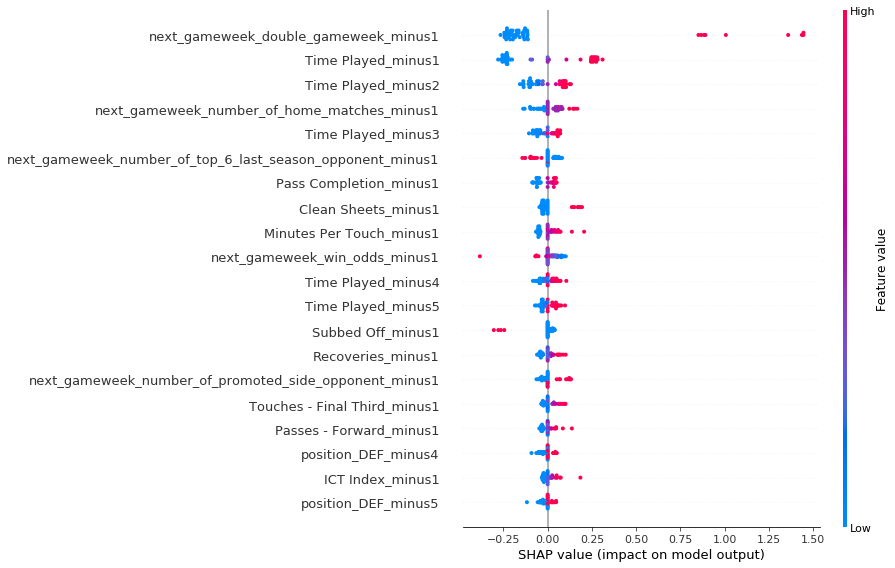

In [41]:
shap.summary_plot(
    shap_values,
    features=test_data.astype(np.float32),
    feature_names=input_data_columns_flattened
)

Main observations:
- Main predictors are previous gameweek features which makes sense
- Direction of impact seems sensible for the features

In [42]:
shap_values.shape

(50, 310)

In [43]:
len(input_data_columns_flattened)

310

In [46]:
shap_df = pd.DataFrame(shap_values, columns=input_data_columns_flattened)
shap_df.head()

,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

Feature importance is the ranking of mean absolute SHAP values for each feature

In [57]:
np.abs(shap_df).mean().sort_values(ascending=False)

next_gameweek_double_gameweek_minus1           0.353639
Time Played_minus1                             0.217971
Time Played_minus2                             0.089663
next_gameweek_number_of_home_matches_minus1    0.056030
Time Played_minus3                             0.049239
                                                 ...   
next_gameweek_double_gameweek_minus4           0.000000
next_gameweek_double_gameweek_minus3           0.000000
double_gameweek_minus3                         0.000000
Premier League Total Red Cards_minus3          0.000000
Premier League Total Red Cards_minus2          0.000000
Length: 310, dtype: float64

Plot feature importance using all time periods of feature

In [61]:
shap_df = shap_df.T.reset_index().rename(columns={'index': 'time_feature'})
shap_df.head()

,time_feature,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,Aerial Duels - Won - Percentage_minus5,-0.004125,0.0,-0.010817,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.010534,0.000000,0.000836,0.0,0.000000,0.000000,0.000000,0.020032,0.0,0.0,0.000000,0.000000,0.000000,-0.001197,0.000000,0.000000,0.0,0.000000,0.010569,0.000000,0.0,-0.007048,0.000000,0.0,0.000357,0.000000,-0.004572,0.0,0.0,0.000000,0.0,0.0,0.00628,0.000000,0.01697,0.000000,0.0,0.000000,0.0
1,Assists_minus5,0.000000,0.0,-0.000296,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-0.004054,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.0
2,Bad Touches_minus5,-0.006870,0.0,0.000000,-0.009107,0.004358,-0.008994,0.0,0.0,0.000000,0.014375,0.0,0.000000,-0.013550,-0.011003,0.0,-0.006128,0.027782,-0.003679,0.000000,0.0,0.0,-0.008261,0.000000,0.032493,-0.012052,-0.007178,0.028634,0.0,0.000000,0.016276,0.032550,0.0,-0.010464,-0.010321,0.0,-0.012547,-0.005527,-0.001710,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.020083,0.0,0.038574,0.0
3,Big Chances Created_minus5,0.000000,0.0,0.000000,0.000000,0.000000,0.034484,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.030994,0.000000,0.000000,0.0,0.0,0.000000,-0.002518,0.000000,-0.004827,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.029308,0.0,0.0,0.00000,0.004672,0.00000,0.032948,0.0,0.000000,0.0
4,Caught Offside_minus5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.004363,0.000000,0.0,0.000000,-0.005603,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.007919,0.000000,-0.002231,0.000000,0.000000,0.000000,0.0,0.044452,0.001528,0.049654,0.0,0.000000,0.000000,0.0,-0.001404,0.000000,-0.003225,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.027598,0.0,0.000000,0.0


In [64]:
shap_df['feature'] = shap_df['time_feature'].str.rsplit('_', 1).apply(lambda x: x[0])

1. Groupby feature, sum SHAP values
2. Take mean of _absolute_ SHAP values for each feature
3. Sort

In [70]:
feature_importance = np.abs(
    shap_df.groupby('feature').sum()
).T.mean().sort_values(ascending=False)

feature_importance

feature
next_gameweek_double_gameweek    0.353639
Time Played                      0.351968
Touches - Final Third            0.099132
position_DEF                     0.088075
Minutes Per Touch                0.084044
                                   ...   
Assists                          0.002163
Handballs                        0.000982
Minutes Per Block                0.000965
gw                               0.000353
double_gameweek                  0.000000
Length: 62, dtype: float64

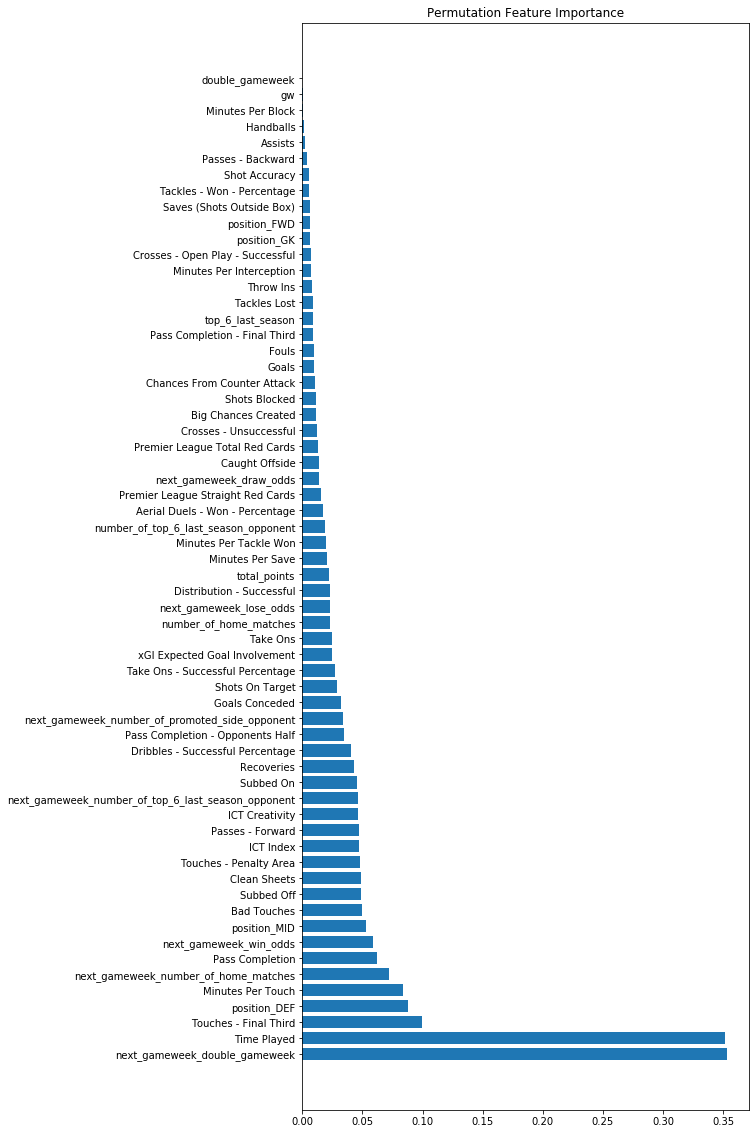

In [72]:
plt.figure(figsize=(8, 20))
plt.barh(
    feature_importance.index, 
    feature_importance.values
)
plt.title('Permutation Feature Importance')
plt.show()

### Individual player predictions

In [57]:
lstm_input_array.shape

(515, 310)

In [58]:
player_data_flattened_df.shape

(515, 310)

In [62]:
len(player_list)

515

raheem_sterling

In [106]:
player_idx = player_list.index('raheem_sterling')
player_idx

417

In [107]:
shap_values = explainer.shap_values(
    lstm_input_array[player_idx, :].astype(np.float32)
)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [108]:
shap_values.shape

(310,)

In [109]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(
    explainer.expected_value, 
    shap_values, 
    lstm_input_array[player_idx, :].astype(np.float32), 
    feature_names=input_data_columns_flattened
)

In [110]:
retro_data[
    (retro_data['name'] == 'raheem_sterling') & 
    (retro_data['gw'] == PREVIOUS_GW-5) & 
    (retro_data['season_order'] == PREDICTION_SEASON_ORDER)
]['Chances From Counter Attack']

112982    2.0
Name: Chances From Counter Attack, dtype: float64

In [112]:
retro_data[
    (retro_data['name'] == 'raheem_sterling') & 
    (retro_data['gw'] == PREVIOUS_GW) & 
    (retro_data['season_order'] == PREDICTION_SEASON_ORDER)
]['next_gameweek_double_gameweek']

135027    1.0
Name: next_gameweek_double_gameweek, dtype: float64

Double gameweek clearly impacts prediction! No longer have to manually adjust :)

In [131]:
pd.DataFrame(
    shap_values.reshape(1, 310), 
    columns=input_data_columns_flattened
)

,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

In [133]:
player_shap_values = pd.DataFrame(
    shap_values.reshape(1, 310), 
    columns=input_data_columns_flattened
).T.reset_index().rename(
    columns={
        'index': 'feature_at_time', 
        0:'shap_value'
    }
)

player_shap_values.sort_values('shap_value', ascending=False, inplace=True)
player_shap_values

,feature_at_time,shap_value
295,next_gameweek_double_gameweek_minus1,1.261921
290,Time Played_minus1,0.261249
297,next_gameweek_lose_odds_minus1,0.193334
5,Chances From Counter Attack_minus5,0.188626
250,Bad Touches_minus1,0.140208
...,...,...
127,Big Chances Created_minus3,0.000000
128,Caught Offside_minus3,0.000000
129,Chances From Counter Attack_minus3,0.000000
309,total_points_minus1,0.000000


In [139]:
player_shap_values['feature'] = player_shap_values['feature_at_time'].str.rsplit('_', 1).apply(lambda x: x[0])

In [144]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).head(10)

,shap_value
feature,
next_gameweek_double_gameweek,1.261921
Time Played,0.380131
Touches - Final Third,0.309801
Touches - Penalty Area,0.246021
xGI Expected Goal Involvement,0.238565
next_gameweek_lose_odds,0.215238
Bad Touches,0.192577
Chances From Counter Attack,0.188626
position_MID,0.156406


mohamed_salah

In [146]:
player_idx = player_list.index('mohamed_salah')
player_idx

362

In [147]:
shap_values = explainer.shap_values(
    lstm_input_array[player_idx, :].astype(np.float32)
)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [148]:
shap_values.shape

(310,)

In [149]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(
    explainer.expected_value, 
    shap_values, 
    lstm_input_array[player_idx, :].astype(np.float32), 
    feature_names=input_data_columns_flattened
)

In [159]:
retro_data[
    (retro_data['name'] == 'mohamed_salah') & 
    (retro_data['gw'] == PREVIOUS_GW) & 
    (retro_data['season_order'] == PREDICTION_SEASON_ORDER)
]['Time Played']

135278    90.0
Name: Time Played, dtype: float64

In [150]:
retro_data[
    (retro_data['name'] == 'mohamed_salah') & 
    (retro_data['gw'] == PREVIOUS_GW) & 
    (retro_data['season_order'] == PREDICTION_SEASON_ORDER)
]['Touches - Final Third']

135278    50.0
Name: Touches - Final Third, dtype: float64

In [153]:
retro_data['Touches - Final Third'].mean()

6.544646879365894

In [154]:
retro_data[
    (retro_data['name'] == 'mohamed_salah') & 
    (retro_data['gw'] == PREVIOUS_GW) & 
    (retro_data['season_order'] == PREDICTION_SEASON_ORDER)
]['Goals']

135278    1.0
Name: Goals, dtype: float64

In [156]:
player_shap_values = pd.DataFrame(
    shap_values.reshape(1, 310), 
    columns=input_data_columns_flattened
).T.reset_index().rename(
    columns={
        'index': 'feature_at_time', 
        0:'shap_value'
    }
)

player_shap_values.sort_values('shap_value', ascending=False, inplace=True)
player_shap_values

,feature_at_time,shap_value
290,Time Played_minus1,0.253671
22,xGI Expected Goal Involvement_minus5,0.199662
291,Touches - Final Third_minus1,0.146544
260,Goals_minus1,0.140973
264,ICT Index_minus1,0.129491
...,...,...
157,Shots Blocked_minus3,-0.006263
102,Take Ons - Successful Percentage_minus4,-0.007686
99,Tackles - Won - Percentage_minus4,-0.011057
298,next_gameweek_number_of_home_matches_minus1,-0.164886


In [160]:
player_shap_values['feature'] = player_shap_values['feature_at_time'].str.rsplit('_', 1).apply(lambda x: x[0])

In [161]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).head(10)

,shap_value
feature,
Time Played,0.506173
Touches - Penalty Area,0.368551
Touches - Final Third,0.365032
xGI Expected Goal Involvement,0.248166
Goals,0.224846
ICT Index,0.214663
Shots On Target,0.188260
position_MID,0.138798
next_gameweek_win_odds,0.138608


ederson_santana de moraes

In [162]:
player_idx = player_list.index('ederson_santana de moraes')
player_idx

144

In [163]:
shap_values = explainer.shap_values(
    lstm_input_array[player_idx, :].astype(np.float32)
)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [164]:
shap_values.shape

(310,)

In [165]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(
    explainer.expected_value, 
    shap_values, 
    lstm_input_array[player_idx, :].astype(np.float32), 
    feature_names=input_data_columns_flattened
)

In [166]:
player_shap_values = pd.DataFrame(
    shap_values.reshape(1, 310), 
    columns=input_data_columns_flattened
).T.reset_index().rename(
    columns={
        'index': 'feature_at_time', 
        0:'shap_value'
    }
)

player_shap_values.sort_values('shap_value', ascending=False, inplace=True)
player_shap_values

,feature_at_time,shap_value
295,next_gameweek_double_gameweek_minus1,1.469536
290,Time Played_minus1,0.304220
297,next_gameweek_lose_odds_minus1,0.210262
228,Time Played_minus2,0.139177
257,Distribution - Successful_minus1,0.121920
...,...,...
127,Big Chances Created_minus3,0.000000
128,Caught Offside_minus3,0.000000
129,Chances From Counter Attack_minus3,0.000000
309,total_points_minus1,0.000000


In [167]:
player_shap_values['feature'] = player_shap_values['feature_at_time'].str.rsplit('_', 1).apply(lambda x: x[0])

In [168]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).head(10)

,shap_value
feature,
next_gameweek_double_gameweek,1.469536
Time Played,0.646382
Minutes Per Touch,0.351804
Distribution - Successful,0.311036
next_gameweek_win_odds,0.226500
next_gameweek_lose_odds,0.221998
next_gameweek_number_of_home_matches,0.184796
Minutes Per Save,0.184734
Pass Completion - Opponents Half,0.112948
